# A basic Demonstration of MetaCast

MetaCast has been developed from the codebase used in [Grunnill et al. (2024)](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1011018). MetaCast's main feature is broad**CAST**ing epidemiological and ecological subpopulation models over multiple dimensions (axis) to form a **META**population model.

This notebook uses a disease X $S E I H R$ (Susceptible - Exposed - Infected - Hospitalised - Recovered) subpopulation model as a motivating example. In possible scenarios in outbreak of disease X that epidemiological modellers my wish to simulate:
1. Risk-Structured: Single Dimension/Axis disease X model.
2. Seeding at X% prevalence: MultinomialSeeder
3. A Rapid Pathogen test: Discrete Event simulation within a 2 dimensional/axis disease X model.
4. New Vaccine: Multi Dimension/Axis disease X model with flows between some subpopulations.
5. New Vaccine's Efficacy is Uncertain: Latin Hypercube Sampling in simulation of a 2 dimensional/axis disease X model.


#### Suggested Reading: Metapopulation and Structured Population Models.

**Note** MetaCast has tried to keep to the mathematical notation seen in the first of the following:

Keeling, M. J., & Rohani, P. (2008). Metapopulations. In Modeling Infectious Diseases in Humans and Animals (pp. 237–240). Princeton University Press.

Keeling, M. J., & Rohani, P. (2008). Age-Structure: Childhood Infections. In Modeling Infectious Diseases in Humans and Animals (pp. 77–92). Pinston University Press.



#### Suggested Reading: Demonstrating a Scenario Analyses that can be Performed using this Package

Grunnill, M., Arino, J., McCarthy, Z., Bragazzi, N. L., Coudeville, L., Thommes, E., Amiche, A., Ghasemi, A., Bourouiba, L., Tofighi, M., Asgary, A., Baky-Haskuee, M., & Wu, J. (2024). Modelling Disease Mitigation at Mass Gatherings: A Case Study of COVID-19 at the 2022 FIFA World Cup. In E. H. Lau (Ed.), PLoS Computational Biology: Vol. January (Issue 1, p. e1011018). Public Library of Science. [https://doi.org/10.1371/JOURNAL.PCBI.1011018](https://doi.org/10.1371/JOURNAL.PCBI.1011018)

# 1. Risk-Structured: Single Dimension/Axis disease X model.

In this section we will be using our model with two groups one at high risk of hospitalisation and another at a low risk, as shown in the equations below. The $r$ subscript denotes risk group, $p_{r}$ denotes the probability of becoming hospitalised for that risk group and $\lambda_{r}$ is the force of infection for that risk group. $\sigma^{-1}$ is the latency period. After $\gamma^{-1}$ days infectious individuals either recover ($1-p_{r}$) or are hospitalised ($p_{r}$). Hospitalised individuals recover after $\eta^{-1}$ days.
$$
    \frac{\delta S_{r}}{\delta t} = -\lambda_{r} S_{r}
$$
$$
    \frac{\delta E_{r}}{\delta t} = \lambda_{r} S_{r} - \sigma E_{r}
$$
$$
    \frac{\delta I_{r}}{\delta t} = \sigma E_{r} - \gamma I_{r}
$$
$$
    \frac{\delta H_{r}}{\delta t} = p_{r} \gamma I_{r} - \eta H_{r}
$$
$$
    \frac{\delta R_{r}}{\delta t} = (1-p_{r}) \gamma I_{r} + \eta H_{r}
$$

The force of infection ($\lambda_{r}$), shown below, for subpopulation $i$ is dependent on the number of infecteds in subpopulation $j$, the strength of interaction between subpopulation those subpopulations ($\rho_{ij}$) and the general transmission term for subpopulation $i$ ($\beta_{i}$).
$$
    \lambda_{i} = \beta_{i} \sum_{j} \rho_{ij} I_j
$$

## 1.1 MetaCaster setup

MetaCast's main workhorse is the MetaCaster class. This needs to be imported.

In [1]:
from metacast import MetaCaster # Import MetaCast's main class MetaCaster.

### 1.1.1 Define subpopulation model.

The subpop_model function is your subpopulation model (see 1.) that MetaCaster will broadcast across the metapopulation generated by your dimensions (see 1.2).
The docstring below explains how the required arguments are used by MetaCaster.

In [2]:
def subpop_model(y, y_deltas, parameters, states_index, subpop_suffix, foi):
    """
    Calculate derivatives of variables in disease X's subpopulation model

    Parameters
    ----------
    y : numpy.Array
        An array of the state variables at this time point.
    y_deltas : numpy.Array
        The derivatives of y at this time. MetaCaster gives y_delta as a numpy array of zeros to which this function adds the derivatives to.
    parameters : dict {str: Number or callable}
        A dictionary of parameter values or callables used to calculate parameter values at this time point.
    subpop_suffix : string
        This string is of the form '_['coodinate_1,coordinate_2,....']' and is appended to a string denoting parameter specifcally applied to this subpopulation. Alternatively a coordinates argument can be given.
    states_index : dict {str:int}
        This dictionary is used to look up the indexes on y and y_delta for states is this subpopulation.
    foi : float
        Force of infection (lambda) experienced be susceptible hosts in this subpopulation. Note the term lambda could not be used as it is used for lambda functions within python. Therefore, the term foi (Force Of Infection) is used.

    Returns
    -------
    y_deltas : numpy.Array
        Derivatives of variables in disease X's subpopulation model.

    """
    infections = foi * y[states_index['S']]
    progression_from_exposed = parameters['sigma'] * y[states_index['E']]
    probability_of_hospitalisation = parameters['p' + subpop_suffix] # this is our subpopulation specific parameter
    progression_from_infectious = y[states_index['I']]*parameters['gamma']
    recovery = progression_from_infectious*(1-probability_of_hospitalisation)
    hospitalisation = progression_from_infectious*probability_of_hospitalisation
    hospital_recovery = y[states_index['H']]*parameters['eta']


    # Updating y_deltas with derivative calculations from this subpopulation.
    y_deltas[states_index['S']] += - infections
    y_deltas[states_index['E']] += infections - progression_from_exposed
    y_deltas[states_index['I']] += progression_from_exposed - progression_from_infectious
    y_deltas[states_index['H']] += hospitalisation - hospital_recovery
    y_deltas[states_index['R']] += recovery+hospital_recovery
    y_deltas[-2] += hospitalisation - hospital_recovery # The last few elements of y_delta can be used for observed states such Total hospital incidence.
    y_deltas[-1] += hospitalisation #or Total hospitalisations.

    return y_deltas

### 1.1.2 Define metapopulation dimensions.

In this first example we are assuming structure comes from just the risk of hospitalisation (low and high). As we are dealing with a one dimension axis metapopulation we can provide a set of strings as our dimensions (a list/tuple of unique strings is also acceptable). **Note** if dealing with a multidimensional metapopulation the dimensions would have to be a list/tuple of sets of strings.

In [3]:
risk_groups = ['low', 'high']

### 1.1.3 Define other model attributes

In [4]:
other_model_attributes = {
    'states': ['S', 'E', 'I', 'H', 'R'], # States of our model
    'infected_states': ['E', 'I'], # Infected states of our model, this is different from infectious states.
    'infectious_states': ['I'], # Infectious states of our model. These will be involved in force of infection calculations.
    'symptomatic_states': ['I', 'H'], # List symptomatic states
    'observed_states': ['H','H_cumulative'], # observed_states is where we name what is being tracked in the last few elements of y_deltas.
    'universal_params': ['sigma', 'gamma', 'eta'], # These are parameters that are not specific to subpopulations.
    'subpop_params': ['p'] # These are parameter that are specific to subpopulation, but not those included in transmission (i.e. beta and rho).
}

### 1.1.3 Intialise MetaCaster.

In [5]:
metapop_model = MetaCaster(dimensions=risk_groups, subpop_model=subpop_model, **other_model_attributes)

*Note* if you are familiar with python you could alternatively initialise your own subclass of MetaCaster with just the dimensions argument. You would need to replace that subclass's subpop_model method and give it the attributes seen in other_model_attributes.

# 1.2 Running model
## 1.2.1 Setting population

For this we will need numpy.

In [6]:
import numpy as np

We need the state_index dictionary for each subpopulation. This gives us our indexes to use on the numpy array defining our initial population $y$.

In [7]:
state_index_dict_high = metapop_model.state_index['high']
state_index_dict_low = metapop_model.state_index['low']
display(state_index_dict_low, state_index_dict_high)

{'S': 5, 'E': 6, 'I': 7, 'H': 8, 'R': 9}

{'S': 0, 'E': 1, 'I': 2, 'H': 3, 'R': 4}

Now we can define $y$.

In [8]:
N = 1e6
proportion_high_risk = 0.1
low_risk_population = N*(1-proportion_high_risk)
high_risk_population = N*proportion_high_risk
y = np.zeros(metapop_model.total_states) # Use the total number of states in our model to define y.
y[state_index_dict_low['S']] = low_risk_population-1
y[state_index_dict_low['I']] = 1
y[state_index_dict_high['S']] = high_risk_population
y

array([1.00000e+05, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       8.99999e+05, 0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00])

### 1.2.2 Setting up parameters

For this we will need to know the names of all of our parameters:

In [9]:
metapop_model.parameter_names

['beta_[high]',
 'beta_[low]',
 'eta',
 'gamma',
 'p_[high]',
 'p_[low]',
 'rho_[high]_[high]',
 'rho_[high]_[low]',
 'rho_[low]_[high]',
 'rho_[low]_[low]',
 'sigma']

Now we can define our parameters in a dictionary.

In [10]:
non_subpop_parameters = {'eta': 1/5, 'gamma': 1/7,  'sigma': 1/3}
p_high = 0.3
p_low = 0.01
hospitalisation_probs = {'p_[high]': p_high, 'p_[low]': p_low}
beta = (2/7)/N
beta_parameters = {'beta'+ subpop_suffix: beta for subpop_suffix in metapop_model.subpop_suffixes}
rho = 1
interaction_parameters = {'rho'+ subpop_suffix_i+subpop_suffix_j: rho
                          for subpop_suffix_i in metapop_model.subpop_suffixes
                          for subpop_suffix_j in metapop_model.subpop_suffixes}
parameters = {**non_subpop_parameters,
              **hospitalisation_probs,
              **beta_parameters,
              **interaction_parameters}
parameters

{'eta': 0.2,
 'gamma': 0.14285714285714285,
 'sigma': 0.3333333333333333,
 'p_[high]': 0.3,
 'p_[low]': 0.01,
 'beta_[high]': 2.857142857142857e-07,
 'beta_[low]': 2.857142857142857e-07,
 'rho_[high]_[high]': 1,
 'rho_[high]_[low]': 1,
 'rho_[low]_[high]': 1,
 'rho_[low]_[low]': 1}

We can now use our parameter dictionary to assign our parameter values.

In [11]:
metapop_model.parameters = parameters

### 1.2.3 Run metapopulation model

Before running our model we need to define our timeframe $t$.

In [12]:
#set time
end_day = 90
time_step = 1
t = np.arange(0, end_day+time_step, time_step)
t

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90])

Now we can use $y$ and $t$ with the integrate method to simulate our model.

In [13]:
results_1 = metapop_model.integrate(y,t)
results_1

high                                                \
                S          E           I          H           R   
0   100000.000000   0.000000    0.000000   0.000000    0.000000   
1    99999.972985   0.022911    0.003908   0.000056    0.000140   
2    99999.947570   0.038014    0.013053   0.000369    0.000994   
3    99999.922182   0.048841    0.024924   0.001041    0.003012   
4    99999.895846   0.057424    0.038181   0.002084    0.006465   
..            ...        ...         ...        ...         ...   
86   99679.171312  64.975344   95.280960  14.350610  146.221775   
87   99650.860927  70.688384  103.675520  15.616509  159.158659   
88   99620.066034  76.899683  112.805318  16.993571  173.235394   
89   99586.570815  83.651946  122.733948  18.491464  188.551827   
90   99550.141119  90.991403  133.530356  20.120679  205.216442   

              low                                                  \
                S           E            I         H            R   
0   899999.000000    0.000000     1.000000  0.000000     0.000000   
1   899998.756863    0.206203     0.902053  0.001220     0.133660   
2   899998.528128    0.342128     0.868956  0.002140     0.258649   
3   899998.299639    0.439570     0.875754  0.002878     0.382159   
4   899998.062612    0.516814     0.908351  0.003510     0.508713   
..            ...         ...          ...       ...          ...   
86  897111.545018  584.777444   857.527688  4.305178  1441.844671   
87  896856.751838  636.194751   933.078650  4.684948  1569.289813   
88  896579.598102  692.096376  1015.246741  5.098066  1707.960715   
89  896278.141473  752.866680  1104.604306  5.547433  1858.840108   
90  895950.274569  818.921720  1201.771874  6.036197  2022.995640   

   observed_states               
                 H H_cumulative  
0         0.000000     0.000000  
1         0.001276     0.001407  
2         0.002509     0.003017  
3         0.003919     0.005066  
4         0.005593     0.007687  
..             ...          ...  
86       18.655788    62.633214  
87       20.301457    68.172298  
88       22.091637    74.199277  
89       24.038897    80.756863  
90       26.156877    87.891455  

[91 rows x 12 columns]

### 1.2.4 Plotting hospitalisations

Let's plot some of the results of our simulation. For this we will need seaborn and pandas.

In [14]:
import seaborn as sns
import pandas as pd

The function below unstacks our reslults so they can be used by seaborn and then plots the number or hospitalisation ($H$) in our subpopulations and observed_states.

In [15]:
def unstack_results_and_plot_hospitalised(results):
    results_unstacked = results.unstack()
    results_unstacked = results_unstacked.reset_index()
    results_unstacked.columns = ['Subpopulation', 'State','t', 'value']
    hospitalised_results = results_unstacked[results_unstacked['State']=='H']
    sns.lineplot(hospitalised_results,x='t',y='value',hue='Subpopulation')
    return results_unstacked

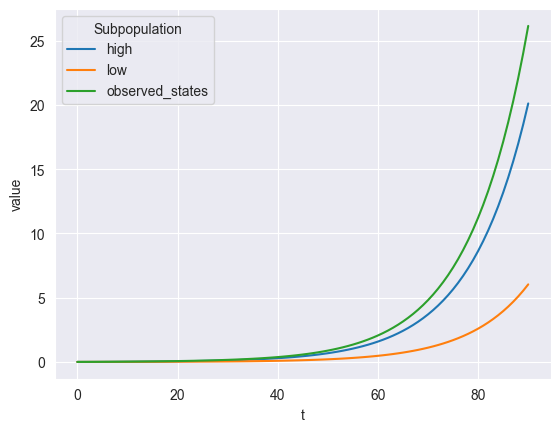

In [16]:
results_1_unstacked = unstack_results_and_plot_hospitalised(results_1)

We can find out the peak hospitilisations and total_hospitalisations using the code below.

In [35]:
hospitalised_records = [
    {'Scenario': 'Single infection at start',
     'Total hospitalisations': results_1.loc[90,('observed_states','H_cumulative')],
     'Peak hospitalisations': max(results_1.loc[:,('observed_states','H')]),
     }
]
pd.DataFrame.from_records(hospitalised_records)

,Scenario,Total hospitalisations,Peak hospitalisations
0,Single infection at start,87.891455,26.156877


# 2. Seeding at X% prevalence: MultinomialSeeder

MetaCast comes with a MultinomialSeeder for seeding infected population randomly drawing probabilities based time spent in compartments. In this example we will use MultinomialSeeder to seed our population with a chosen prevalence before running the model defined in the previous section.

## 2.1 Set up Seeders

For this we need to import metacast MultinomialSeeder

In [20]:
from metacast import MultnomialSeeder

Then we need to define a seeding information dictionary for MultinomialSeeder. This seeding information is a nested dictionary. The first level keys are the possible branches of your infecteds (infection course). The lowest level keys are the states with values being the rate at which people leave that state.

In [21]:
seeding_info = {'unhospitalised': {'E': 'sigma','I':'gamma'},
                'hospitalised': {'E': 'sigma','I':'gamma', 'H':'eta'},
                }
seeder = MultnomialSeeder(seeding_info)
seeder.set_seed(42) # This class uses random number generation (rng) use set_seed function to set rng seed.

## 2.2 Setup Populations with seeder

We can now random draws for our low and high risk population for a given prevalence.

In [26]:
prevelance = 0.01
low_risk_total_infected = low_risk_population*prevelance
low_risk_infected = seeder.seed_infections(n=low_risk_total_infected,
                                           branch_probability={'unhospitalised': 1- parameters['p_[low]'] ,'hospitalised': parameters['p_[low]']},
                                           parameters=parameters)
low_risk_infected

{'E': 2666, 'H': 29, 'I': 6305}

In [27]:
high_risk_total_infected = high_risk_population*prevelance
high_risk_infected = seeder.seed_infections(n=high_risk_total_infected,
                                            branch_probability={'unhospitalised': 1- parameters['p_[high]'] ,'hospitalised': parameters['p_[high]']},
                                            parameters=parameters)
high_risk_infected

{'E': 280, 'H': 98, 'I': 622}

Now we can use those draws in setting up our high and low risk populations.

In [29]:
y =np.zeros(metapop_model.total_states)
low_risk_state_pops = {'S':low_risk_population*(1-prevelance), **low_risk_infected}
for state, index in state_index_dict_low.items():
    if state in low_risk_state_pops:
        y[index] = low_risk_state_pops[state]

y

array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 8.910e+05,
       2.666e+03, 6.305e+03, 2.900e+01, 0.000e+00, 0.000e+00, 0.000e+00])

In [30]:
high_risk_state_pops = {'S':high_risk_population*(1-prevelance), **high_risk_infected}
for state, index in state_index_dict_high.items():
    if state in high_risk_state_pops:
        y[index] = high_risk_state_pops[state]

y[-2] += low_risk_state_pops['H'] + high_risk_state_pops['H']
y

array([9.900e+04, 2.800e+02, 6.220e+02, 9.800e+01, 0.000e+00, 8.910e+05,
       2.666e+03, 6.305e+03, 2.900e+01, 0.000e+00, 1.270e+02, 0.000e+00])

### 2.3 Run metapopulation model

The code below runs the model with our new starting population $y$.

In [31]:
results_seeded = metapop_model.integrate(y,t)
results_seeded

high                                                     \
               S           E            I           H             R   
0   99000.000000  280.000000   622.000000   98.000000      0.000000   
1   98802.993249  368.246146   640.872136  104.689037     83.199433   
2   98599.438316  437.184863   681.254793  111.360842    170.761187   
3   98384.486093  496.366708   735.938462  118.695858    264.512879   
4   98154.779824  551.386570   800.954304  127.041904    365.837398   
..           ...         ...          ...         ...           ...   
86  22669.055509  710.494069  2901.797307  857.807879  72860.845236   
87  22487.498244  663.190895  2728.593801  811.524396  73309.192664   
88  22318.153431  618.930787  2564.242830  767.081340  73731.591612   
89  22160.214040  577.536206  2408.482746  724.483779  74129.283229   
90  22012.923827  538.836815  2261.032724  683.725299  74503.481336   

              low                                                        \
                S            E             I           H              R   
0   891000.000000  2666.000000   6305.000000   29.000000       0.000000   
1   889226.939239  3418.828882   6419.145449   31.957989     903.128441   
2   887394.944840  4009.622663   6723.411956   34.663449    1837.357092   
3   885460.374840  4521.010768   7156.463050   37.363403    2824.787939   
4   883393.018419  5000.964310   7684.780863   40.200950    3881.035457   
..            ...          ...           ...         ...            ...   
86  204021.499585  6394.446621  26116.180207  257.342474  663210.531112   
87  202387.484192  5968.718056  24557.348059  243.457415  666842.992278   
88  200863.380879  5570.377083  23078.188807  230.124485  670257.928746   
89  199441.926363  5197.825852  21676.347612  217.345206  673466.554967   
90  198116.314439  4849.531334  20349.297022  205.117652  676479.739553   

   observed_states                
                 H  H_cumulative  
0       127.000000      0.000000  
1       136.647026     36.027405  
2       146.024291     73.666814  
3       156.059261    113.894135  
4       167.242854    157.386155  
..             ...           ...  
86     1115.150353  28720.584670  
87     1054.981811  28877.389615  
88      997.205825  29024.792418  
89      941.828984  29163.279104  
90      888.842951  29293.320563  

[91 rows x 12 columns]

### 2.4 Plotting hospitalisations

,Subpopulation,State,t,value
0,high,S,0,99000.000000
1,high,S,1,98802.993249
2,high,S,2,98599.438316
3,high,S,3,98384.486093
4,high,S,4,98154.779824
...,...,...,...,...
1087,observed_states,H_cumulative,86,28720.584670
1088,observed_states,H_cumulative,87,28877.389615
1089,observed_states,H_cumulative,88,29024.792418
1090,observed_states,H_cumulative,89,29163.279104


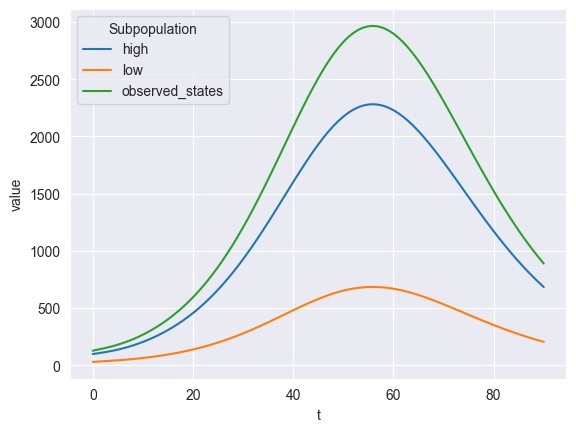

In [32]:
unstack_results_and_plot_hospitalised(results_seeded)

Let's compare with Total hospitalised and Peak Hospitalised from previous scenarios.

In [36]:
hospitalised_records.append(
    {'Scenario': 'Starting prevalence of ' + str(prevelance),
     'Total hospitalisations': results_seeded.loc[90,('observed_states','H_cumulative')],
     'Peak hospitalisations': max(results_seeded.loc[:,('observed_states','H')]),
     }
)
pd.DataFrame.from_records(hospitalised_records)

,Scenario,Total hospitalisations,Peak hospitalisations
0,Single infection at start,87.891455,26.156877
1,starting prevelance or 0.01,29293.320563,2966.416138


# 3. A Rapid Pathogen test: Discrete Event simulation within a 2 dimensional/axis disease X model.

In this scenario we are going to assume that a new affordable rapid test for disease X has become available. Positive tests result in those in states $E$ or $I$ being moved to an isolating test positive population. For this scenario we will need to:
 * Extend our metapopulation dimensions for those who tested postive and negative.
  * Set up a MetaCast's event que with the new rapid pathogen test as a discrete event.

The equation for the model in this scenario very similar to the previous scenario's. The subscript $q$ has been added to denote those isolating (in quarantine) as the result of a positive test for disease X.
$$
    \frac{\delta S_{r,q}}{\delta t} = -\lambda_{r,q} S_{r,q}
$$
$$
    \frac{\delta E_{r,q}}{\delta t} = \lambda_{r,q} S_{r,q} - \sigma E_{r,q}
$$
$$
    \frac{\delta I_{r,q}}{\delta t} = \sigma E_{r,q} - \gamma I_{r,q}
$$
$$
    \frac{\delta H_{r,q}}{\delta t} = p_{r,q} \gamma I_{r,q} - \eta H_{r,q}
$$
$$
    \frac{\delta R_{r,q}}{\delta t} = (1-p_{r,q}) \gamma I_{r,q} + \eta H_{r,q}
$$
$$
    \lambda_{i} = \beta_{i} \sum_{j} \rho_{ij} I_j
$$


## 3.1 Change Population Structure

Lets start be changing the dimensions of our metapopulation by adding a new dimension for those who tested positive and those who tested negative.

In [ ]:
isolation_groups = ['negative','positive']
rapid_pathogen_test_dimensions = [risk_groups,isolation_groups]

In [ ]:
metapop_model.dimensions = rapid_pathogen_test_dimensions
metapop_model.dimensions

## 3.2 Set Population

We need to change our starting population as a result of the change in our metapopulation model's dimensions.

In [ ]:
y =np.zeros(metapop_model.total_states)
low_risk_state_pops = {'S':low_risk_population*(1-prevelance), **low_risk_infected}
for state, index in metapop_model.state_index[('low', 'negative')].items():
    if state in low_risk_state_pops:
        y[index] = low_risk_state_pops[state]
high_risk_state_pops = {'S':high_risk_population*(1-prevelance), **high_risk_infected}
for state, index in metapop_model.state_index[('high', 'negative')].items():
    if state in high_risk_state_pops:
        y[index] = high_risk_state_pops[state]

y[-2] += low_risk_state_pops['H'] + high_risk_state_pops['H']
y

## 3.3 Set parameters

We also need to change our parameter values as a result of the change in our metapopulation model's dimensions.

In [ ]:
metapop_model.parameter_names

In [ ]:
beta_parameters = {'beta' + subpop_suffix: beta for subpop_suffix in metapop_model.subpop_suffixes}
isolation_hospitalisation_probs = {
    **{'p_[high,'+ isolation_group +']': hospitalisation_probs['p_[high]'] for isolation_group in isolation_groups},
    **{'p_[low,'+ isolation_group +']': hospitalisation_probs['p_[low]'] for isolation_group in isolation_groups}
}

These new parameters need to account of the effect of isolation on the strength of transmission between populations $\rho_{ij}$.

In [ ]:
transmission_reduction_from_isolation = 0.6
interaction_parameters = {
    **{'rho'+ subpop_suffix_i+'_['+risk_group +',negative]': rho
       for subpop_suffix_i in metapop_model.subpop_suffixes
       for risk_group in risk_groups},
    **{'rho'+ subpop_suffix_i+'_['+risk_group +',positive]': rho*(1-transmission_reduction_from_isolation)
       for subpop_suffix_i in metapop_model.subpop_suffixes
       for risk_group in risk_groups}
}
interaction_parameters

In [ ]:
parameters = {**non_subpop_parameters,
              **isolation_hospitalisation_probs,
              **beta_parameters,
              **interaction_parameters}
metapop_model.parameters = parameters

## 3.4 Set up Event Que

First we need to import the EventQueue and TransferEvent

In [ ]:
from metacast.event_handling import EventQueue, TransferEvent

For those that would isolate if they comply with isolation order on a positive test we need the following:
 * The indexes of their current compartment (a from_index).
  * The index of the corresponding isolation compartment they would move to (a to_index).

In [ ]:
from_index = [index
              for risk_group in risk_groups
              for state, index in metapop_model.state_index[(risk_group,'negative')].items()
              if state in ['E','I']]
to_index = [index
            for risk_group in risk_groups
            for state, index in metapop_model.state_index[(risk_group,'positive')].items()
            if state in ['E','I']]
display({'from index': from_index,'to index': to_index})

With our from_index and to_index we can set up a TransferEvent as our 'Rapid Pathogen Test'. The TransferEvent will also need:
 * A range of time at which to be triggered.
  * The proportion of population to move between the compartments in our from_index and to_index.
* A name.

In [ ]:
test_every_x_days = 7
complaince = 0.8
test_sensitivity = 0.6
rapid_pathogen_test_event = TransferEvent(name='Rapid Pathogen Test',
                                          times= range(0,end_day+time_step,test_every_x_days),
                                          proportion= test_sensitivity*complaince,
                                          from_index= from_index,
                                          to_index= to_index)

With our 'Rapid Pathogen Test' set up we can set up our event que.

In [ ]:
testing_eventqueue = EventQueue(rapid_pathogen_test_event)

**Note** you can setup the EventQueue with multiple event using a list. There are also more event types available than just the TransferEvent see [https://metacast.readthedocs.io/en/latest/autoapi/metacast/event_handling/events/index.html](https://metacast.readthedocs.io/en/latest/autoapi/metacast/event_handling/events/index.html).

## 3.5 Run simulations with Events

In [ ]:
results_rapid_test, transfer_df = testing_eventqueue.run_simulation(model_object=metapop_model,
                                                                    run_attribute='integrate',
                                                                    parameters=parameters,
                                                                    parameters_attribute='parameters',
                                                                    y0=y,
                                                                    end_time=end_day,
                                                                    start_time=0,
                                                                    simulation_step=time_step)
results_rapid_test

In [ ]:
transfer_df

### 3.6 Plotting hospitalisations

In [ ]:
results_rapid_test_unstacked = unstack_results_and_plot_hospitalised(results_rapid_test)

Let's compare with Total hospitalised and Peak Hospitalised from previous scenarios.

In [36]:
hospitalised_records.append(
    {'Scenario': 'Tests every ' + str(test_every_x_days) + ' day resulting in ' + str(complaince*test_sensitivity) + ' in isolation ('+
                 str(1-transmission_reduction_from_isolation) + ' transmission).',
     'Total hospitalisations': results_rapid_test.loc[90,('observed_states','H_cumulative')],
     'Peak hospitalisations': max(results_rapid_test.loc[:,('observed_states','H')])
     }
)
pd.DataFrame.from_records(hospitalised_records)

,Scenario,Total hospitalisations,Peak hospitalisations
0,Single infection at start,87.891455,26.156877
1,starting prevelance or 0.01,29293.320563,2966.416138


## 3.6 Comparing with Rapid test event turned to null (do nothing) event.

In [ ]:
metapop_model.state_index

In [ ]:
rapid_pathogen_test_event.make_event_a_nullevent()
results_rapid_test_null, transfer_df = testing_eventqueue.run_simulation(model_object=metapop_model,
                                                                         run_attribute='integrate',
                                                                         parameters=parameters,
                                                                         parameters_attribute='parameters',
                                                                         y0=y,
                                                                         end_time=end_day,
                                                                         start_time=0,
                                                                         simulation_step=time_step)
results_rapid_test_null

In [ ]:
transfer_df

In [ ]:
results_rapid_test_null_unstacked = unstack_results_and_plot_hospitalised(results_rapid_test_null)

Let's compare with Total hospitalised and Peak Hospitalised from previous scenarios.

In [36]:
hospitalised_records.append(
    {'Scenario': 'Do nothing event.',
     'Total hospitalisations': results_rapid_test_null.loc[90,('observed_states','H_cumulative')],
     'Peak hospitalisations': max(results_rapid_test_null.loc[:,('observed_states','H')])
     }
)
pd.DataFrame.from_records(hospitalised_records)

,Scenario,Total hospitalisations,Peak hospitalisations
0,Single infection at start,87.891455,26.156877
1,starting prevelance or 0.01,29293.320563,2966.416138


# 4. Two New Vaccines of known efficacy: Multi Dimension/Axis disease X model with flows between subpopulations.

## 4.1 Set metapopulation structure using a list of subpopulation transfer dictionaries for a dimensions.

In [ ]:
vaccination_groups = ['unvaccinated','vaccination_lag' 'vaccinated']
vaccination_transfers = [{'from_coordinates': (risk_group,'unvaccinated'),
                          'to_coordinates': (risk_group,'vaccination_lag'),
                          'states': ['S'], 'parameter': 'nu_0'}
                         for risk_group in risk_groups]
vacination_lag_transfers = [{'from_coordinates': (risk_group,'vaccination_lag'),
                             'to_coordinates': (risk_group,'vaccinated'),
                             'states': 'all', 'parameter': 'nu_1'}
                            for risk_group in risk_groups]

vaccination_dimensions = vaccination_transfers + vacination_lag_transfers
vaccination_dimensions

In [ ]:
metapop_model.dimensions = vaccination_dimensions
metapop_model.dimensions

## 4.2 Set population

In [ ]:
metapop_model.total_states

In [ ]:
y = np.zeros(metapop_model.total_states)

for state, index in metapop_model.state_index[('high','unvaccinated')].items():
    if state in high_risk_state_pops:
        y[index] = high_risk_state_pops[state]

for state, index in metapop_model.state_index[('low','unvaccinated')].items():
    if state in low_risk_state_pops:
        y[index] =low_risk_state_pops[state]

y[-2] += low_risk_state_pops['H'] + high_risk_state_pops['H']
y

## 4.3 Set parameters

In [ ]:
metapop_model.parameter_names

In [ ]:
def vaccination_parameters_setup(nu_0,
                                 nu_1,
                                 l_v,
                                 h_v,
                                 other_parameters,
                                 metapop_model):
    parameters = {key: value for key, value in other_parameters.items() if key in metapop_model.parameter_names}
    parameters.update({'nu_0': nu_0,
                       'nu_1': nu_1})

    beta = other_parameters['beta']
    parameters.update({'beta_[high,unvaccinated]': beta,
                       'beta_[high,vaccinated]': beta*(1-l_v),
                       'beta_[high,vaccination_lag]': beta,
                       'beta_[low,unvaccinated]': beta,
                       'beta_[low,vaccinated]': beta*(1-l_v),
                       'beta_[low,vaccination_lag]': beta})

    if h_v < l_v:
        raise ValueError('h_v must be greater than or equal to l_v. ' +
                         'Otherwise vaccine reduced severity given reduced susceptibility is negative.')

    vaccine_reduced_severity_given_reduced_susceptibility = 1-((1-h_v)/(1-l_v))
    p_high = other_parameters['p_[high]']
    p_low = other_parameters['p_[low]']
    parameters.update({'p_[high,unvaccinated]': p_high,
                       'p_[high,vaccinated]': p_high*(1-vaccine_reduced_severity_given_reduced_susceptibility),
                       'p_[high,vaccination_lag]': p_high,
                       'p_[low,unvaccinated]': p_low,
                       'p_[low,vaccinated]': p_low*(1-vaccine_reduced_severity_given_reduced_susceptibility),
                       'p_[low,vaccination_lag]': p_low})
    rho = other_parameters['rho']
    parameters.update({'rho'+ subpop_suffix_i+subpop_suffix_j: rho
                       for subpop_suffix_i in metapop_model.subpop_suffixes
                       for subpop_suffix_j in metapop_model.subpop_suffixes})
    return parameters

def prob_over_many_days_to_prob_on_a_day(prob, many_days):
    return 1-(1-prob)**(1/many_days)

In [ ]:
v_day = end_day
prob_vaccinated_by_v_day = 0.7

prob_vaccinated_per_day = prob_over_many_days_to_prob_on_a_day(prob_vaccinated_by_v_day ,v_day)
vaccination_lag = 1/14
vaccine_reduced_susceptibility = 0.4
vaccine_reduced_severity = 0.8
other_parameters = {'beta':beta, 'rho': rho, **non_subpop_parameters, **hospitalisation_probs}
parameters = vaccination_parameters_setup(nu_0=prob_vaccinated_per_day*complaince,
                                          nu_1=vaccination_lag,
                                          l_v=vaccine_reduced_susceptibility,
                                          h_v=vaccine_reduced_severity,
                                          other_parameters=other_parameters,
                                          metapop_model=metapop_model)
parameters

In [ ]:
metapop_model.parameters = parameters

### 4.4 Run metapopulation model

In [ ]:
results_vaccination = metapop_model.integrate(y,t)
results_vaccination

### 4.5 Plotting hospitalisations

In [ ]:
results_vaccination_unstacked = unstack_results_and_plot_hospitalised(results_vaccination)

Let's compare with Total hospitalised and Peak Hospitalised from previous scenarios.

In [36]:
hospitalised_records.append(
    {'Scenario': 'Vaccinating ' + str(prob_vaccinated_by_v_day) + ' population by day '+ str(v_day),
     'Total hospitalisations': results_vaccination.loc[90,('observed_states','H_cumulative')],
     'Peak hospitalisations': max(results_vaccination.loc[:,('observed_states','H')])
     }
)
pd.DataFrame.from_records(hospitalised_records)

,Scenario,Total hospitalisations,Peak hospitalisations
0,Single infection at start,87.891455,26.156877
1,starting prevelance or 0.01,29293.320563,2966.416138


# 5. New Vaccine's Efficacy is Uncertain: Latin Hypercube Sampling in simulation of a 2 dimensional/axis disease X model.

## 5.1 Setup class for running

In [ ]:
def vaccination_lhs_sim(sample, metapop_model, t, y0, fixed_parameter):
    parameters = vaccination_parameters_setup(**sample, other_parameters=fixed_parameter,
                                              metapop_model=metapop_model)
    metapop_model.parameters = parameters
    results = metapop_model.integrate(y0, t)
    focused_results = {'Total hospitalisations': results.loc[90, ('observed_states', 'H_cumulative')],
                       'Peak hospitalisations': max(results.loc[:, ('observed_states', 'H')])}
    results_and_sample = sample | focused_results
    return results_and_sample

## 5.2 Setup parameter ranges to sample from.

**Note** currently metacast only support latin hypercube sampling with uniform distributions.

In [ ]:
parameter_samples_records = [
    {'parameter': 'nu_0', 'Lower Bound': prob_over_many_days_to_prob_on_a_day(0.5, v_day), 'Upper Bound': prob_over_many_days_to_prob_on_a_day(0.95, v_day)},
    {'parameter': 'nu_1', 'Lower Bound': 1/28, 'Upper Bound': 1/7},
    {'parameter': 'l_v', 'Lower Bound': 0.3, 'Upper Bound': 0.6},
    {'parameter': 'h_v', 'Lower Bound': 0.7, 'Upper Bound': 0.95}
]
parameter_samples_df = pd.DataFrame.from_records(parameter_samples_records)
parameter_samples_df.set_index('parameter',inplace=True)
parameter_samples_df

##  5.3 Run simulations with LHS

In [ ]:
from metacast.sensitivity_analyses import lhs_prcc

In [ ]:
results_and_sample_df, prccs = lhs_prcc(parameters_df=parameter_samples_df,
                                        sample_size=10,
                                        model_run_method=vaccination_lhs_sim,
                                        metapop_model=metapop_model,
                                        t=t,
                                        y0=y,
                                        fixed_parameter=other_parameters)
results_and_sample_df

In [ ]:
prccs

##  5.4 Run simulations with LHS in parallell

In [ ]:
import os
number_cpu = os.cpu_count()
number_cpu

In [ ]:
# setup the dask cluster
import dask

client = dask.distributed.Client(n_workers=number_cpu-1, threads_per_worker=1)
client

In [ ]:
results_and_sample_df, prccs = lhs_prcc(parameters_df=parameter_samples_df,
                                        sample_size=1000,
                                        model_run_method=vaccination_lhs_sim,
                                        metapop_model=metapop_model,
                                        client= client,
                                        t=t,
                                        y0=y,
                                        fixed_parameter=other_parameters)

In [ ]:
client.close()

In [ ]:
prccs